<a href="https://colab.research.google.com/github/DeusExMachina1993/Deep-Computer-Vision/blob/master/Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# For downloading dataset
from urllib.request import urlretrieve
import os

# For extracting dataset
import tarfile

# For reading images
import cv2

# Essentials :)
import numpy as np

# pretty printing python objects
import pprint

# for sorting dictionary by value
import operator

# for showing images inline
from matplotlib.pyplot import imshow 
%matplotlib inline 

# for making labels one-hot encoded
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# for splitting data into training and validation data
from sklearn.model_selection import train_test_split

# for CNN and NN models
from keras.models import Sequential, Model
from keras.layers import Conv2D, Input, Dropout, Activation, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model

# For transfer learning
from keras.applications.inception_v3 import InceptionV3

# to save models
import json

# for saving environment of notebook
import dill

# for printing size each variable is using
import sys

Using TensorFlow backend.


Download the dataset to a folder inside this directory

In [5]:
URL_CALTECH_101_DATA = 'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'

def download_dataset(url):
    current_directory = os.path.dirname(os.path.realpath('__file__'))
    dataset_file_path = current_directory+"/dataset.tgz"
    if os.path.exists(dataset_file_path):
        print("Already downloaded.")
    else:
        filename, headers = urlretrieve(url, dataset_file_path)        
    print("Done")

download_dataset(URL_CALTECH_101_DATA)

Already downloaded.
Done


In [6]:

def extract_dataset(dataset_file_path, extraction_directory):
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)
    if (dataset_file_path.endswith("tar.gz") or dataset_file_path.endswith(".tgz")):
        tar = tarfile.open(dataset_file_path, "r:gz")
        tar.extractall(path=extraction_directory)
        tar.close()
    elif (dataset_file_path.endswith("tar")):
        tar = tarfile.open(dataset_file_path, "r:")
        tar.extractall(path=extraction_directory)
        tar.close()
    print("Done")

extract_dataset('./dataset.tgz','./data/')

Done


Exploring dataset

In [0]:
def get_images(object_category, data_directory):
    if (not os.path.exists(data_directory)):
        print("Data directory not found. Are you sure you downloaded and extracted dataset properly?")
        return
    obj_category_dir = os.path.join(os.path.join(data_directory,"101_ObjectCategories"),object_category)
    images = [os.path.join(obj_category_dir,img) for img in os.listdir(obj_category_dir)]
    return images

def read_image(image_path):
    """Read and resize individual images - Caltech 101 avg size of image is 300x200, so we resize accordingly"""
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (300,200), interpolation=cv2.INTER_CUBIC)
    return img

In [0]:
dolphin_imgs = get_images('dolphin','./data')

In [9]:
dolphin_imgs[0]

'./data/101_ObjectCategories/dolphin/image_0028.jpg'

In [0]:
dolphin_test_img = read_image(dolphin_imgs[0])

In [11]:
dolphin_test_img.shape

(200, 300, 3)

How many images we have for each category?

In [0]:
def return_images_per_category(data_directory):
    categories = os.listdir(data_directory+"/101_ObjectCategories/")
    object_images_count_dict = {}
    for category in categories:
        object_images_count_dict[category] = len(os.listdir(data_directory+"/101_ObjectCategories/"+category))
    object_images_count_dict = sorted(object_images_count_dict.items(), key=operator.itemgetter(1), reverse=True)
    return object_images_count_dict

In [13]:
return_images_per_category('./data')

[('airplanes', 800),
 ('Motorbikes', 798),
 ('BACKGROUND_Google', 468),
 ('Faces', 435),
 ('Faces_easy', 435),
 ('watch', 239),
 ('Leopards', 200),
 ('bonsai', 128),
 ('car_side', 123),
 ('ketch', 114),
 ('chandelier', 107),
 ('hawksbill', 100),
 ('grand_piano', 99),
 ('brain', 98),
 ('butterfly', 91),
 ('helicopter', 88),
 ('menorah', 87),
 ('kangaroo', 86),
 ('trilobite', 86),
 ('starfish', 86),
 ('ewer', 85),
 ('buddha', 85),
 ('sunflower', 85),
 ('scorpion', 84),
 ('revolver', 82),
 ('laptop', 81),
 ('ibis', 80),
 ('llama', 78),
 ('minaret', 76),
 ('umbrella', 75),
 ('electric_guitar', 75),
 ('crab', 73),
 ('crayfish', 70),
 ('cougar_face', 69),
 ('dragonfly', 68),
 ('dalmatian', 67),
 ('ferry', 67),
 ('flamingo', 67),
 ('lotus', 66),
 ('dolphin', 65),
 ('soccer_ball', 64),
 ('euphonium', 64),
 ('stop_sign', 64),
 ('elephant', 64),
 ('joshua_tree', 64),
 ('schooner', 63),
 ('chair', 62),
 ('lamp', 61),
 ('yin_yang', 60),
 ('rhino', 59),
 ('cellphone', 59),
 ('wheelchair', 59),
 ('s

In [14]:
len(return_images_per_category('./data'))

102

In [0]:

def create_training_data(data_directory):
    i = 0
    X = np.ndarray((8677, 200, 300, 3), dtype=np.uint8)
    Y = []
    print("Preparing X and Y for dataset...")
    for category,_ in return_images_per_category(data_directory):
        if category == 'BACKGROUND_Google':
            continue
        print("Processing images of ",category)
        for image in get_images(category, data_directory):
            if not image.endswith('.jpg'):
                # to escape hidden ipynb checkpoints and other unnecessary files 
                continue
            X[i] = read_image(image)
            Y.insert(i,category) 
            i += 1
        print("Images processed : ",i+1," of 8678")
    print("Datasets constructed")
    return X,Y

In [16]:
X, Y = create_training_data('./data')

Preparing X and Y for dataset...
Processing images of  airplanes
Images processed :  801  of 8678
Processing images of  Motorbikes
Images processed :  1599  of 8678
Processing images of  Faces
Images processed :  2034  of 8678
Processing images of  Faces_easy
Images processed :  2469  of 8678
Processing images of  watch
Images processed :  2708  of 8678
Processing images of  Leopards
Images processed :  2908  of 8678
Processing images of  bonsai
Images processed :  3036  of 8678
Processing images of  car_side
Images processed :  3159  of 8678
Processing images of  ketch
Images processed :  3273  of 8678
Processing images of  chandelier
Images processed :  3380  of 8678
Processing images of  hawksbill
Images processed :  3480  of 8678
Processing images of  grand_piano
Images processed :  3579  of 8678
Processing images of  brain
Images processed :  3677  of 8678
Processing images of  butterfly
Images processed :  3768  of 8678
Processing images of  helicopter
Images processed :  3856  o

In [17]:
X.shape

(8677, 200, 300, 3)

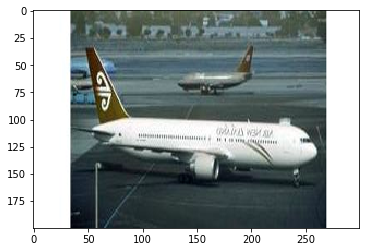

In [18]:
imshow(X[0])

In [19]:
Y[0]

'airplanes'

In [0]:
WINDOW_SIZES = [i for i in range(20, 160, 20)]


def get_best_bounding_box(img, predict_fn, step=10, window_sizes=WINDOW_SIZES):
    best_box = None
    best_box_prob = -np.inf

    # loop window sizes: 20x20, 30x30, 40x40...160x160
    for win_size in window_sizes:
        for top in range(0, img.shape[0] - win_size + 1, step):
            for left in range(0, img.shape[1] - win_size + 1, step):
                # compute the (top, left, bottom, right) of the bounding box
                box = (top, left, top + win_size, left + win_size)

                # crop the original image
                cropped_img = img[box[0]:box[2], box[1]:box[3]]

                # predict how likely this cropped image is dog and if higher
                # than best save it
                #print('predicting for box %r' % (box, ))
                box_prob = predict_fn(cropped_img)
                if box_prob > best_box_prob:
                    best_box = box
                    best_box_prob = box_prob

    return best_box

In [0]:
import random
import numpy as np
random.seed(0)
def predict_function(x):
    # example of prediction function for simplicity, you
    # should probably use `return model.predict(x)`
    
    return random.random()

In [36]:
best_box = get_best_bounding_box(X[2], predict_function)
print('best bounding box %r' % (best_box, ))

best bounding box (40, 130, 140, 230)
